In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Importing necessary libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf 

2025-06-21 03:10:11.518717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750475411.725090      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750475411.790582      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Preparing the data (train, test)

In [3]:
train_data_path=r'/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data_path=r'/kaggle/input/intel-image-classification/seg_test/seg_test'

In [4]:
# Preparing the training dataset
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    subset="training",
    validation_split=0.2,
    seed=50,
    shuffle=True,
)

# Preparing the validation dataset
val_data = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    subset="validation",
    validation_split=0.2,
    seed=50,
    shuffle=True,
)

# Preparing the test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    batch_size=32,
    image_size=(256, 256),
    color_mode="rgb",
)
classes = train_data.class_names

Found 14034 files belonging to 6 classes.
Using 11228 files for training.


I0000 00:00:1750475427.063098      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750475427.063777      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


##### Displaying images in the training data

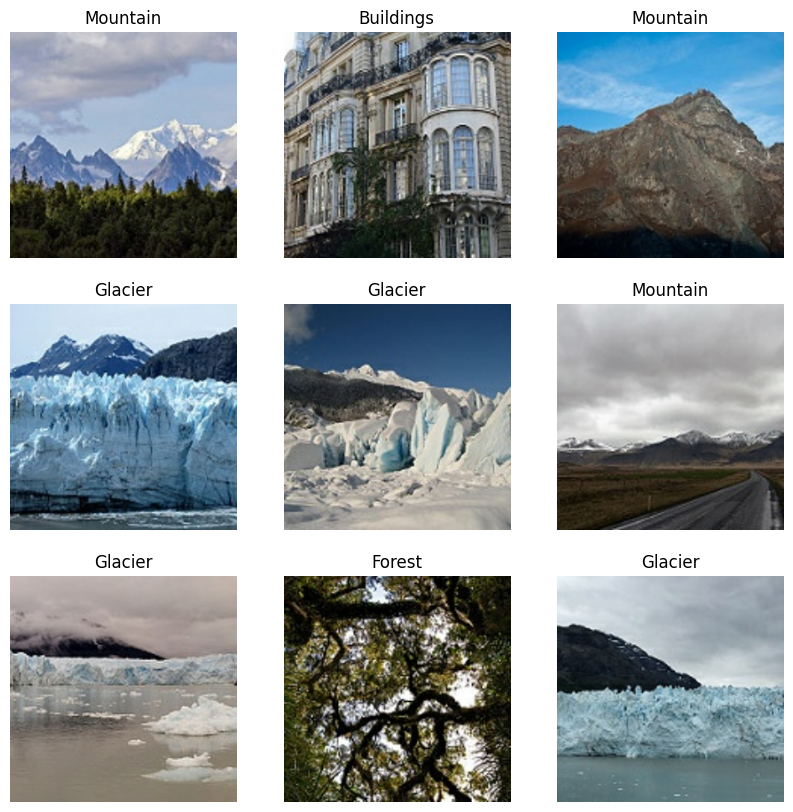

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]].title())
        plt.axis("off")
plt.show()

#### Data Augmentation

In [6]:
augmented_data = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_data.map(lambda x, y: (augmented_data(x), y))

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### Building the CNN

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    augmented_data,

    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,813,766 (25.99 MB)

 Trainable params: 6,812,806 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

#### Early stopping

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [10]:
# Fit the model
model_history = model.fit(train_data, epochs=100, validation_data=val_data, batch_size=32, callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1750475438.511854     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 160ms/step - accuracy: 0.3399 - loss: 4.8629 - val_accuracy: 0.4034 - val_loss: 1.4922
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 57s 163ms/step - accuracy: 0.3682 - loss: 1.5185 - val_accuracy: 0.3888 - val_loss: 1.5269
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - accuracy: 0.3796 - loss: 1.4584 - val_accuracy: 0.4448 - val_loss: 1.2276
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - accuracy: 0.3662 - loss: 1.4494 - val_accuracy: 0.5110 - val_loss: 1.2191
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.4172 - loss: 1.3779 - val_accuracy: 0.4993 - val_loss: 1.2190
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.4207 - loss: 1.3617 - val_accuracy: 0.6148 - val_loss: 1.0717
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.4379 - loss: 1.3143 - val_accuracy: 0.6661 - val_loss: 0.9622
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.4671 - loss: 1.245

In [11]:
# Saving the model
model.save('classifier.keras')

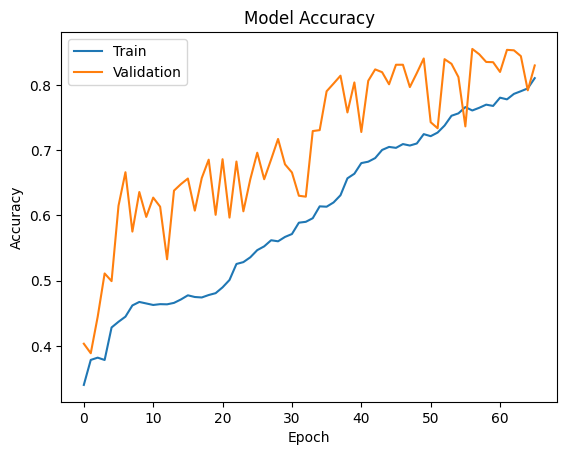

In [12]:
# Accuracy history summary
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

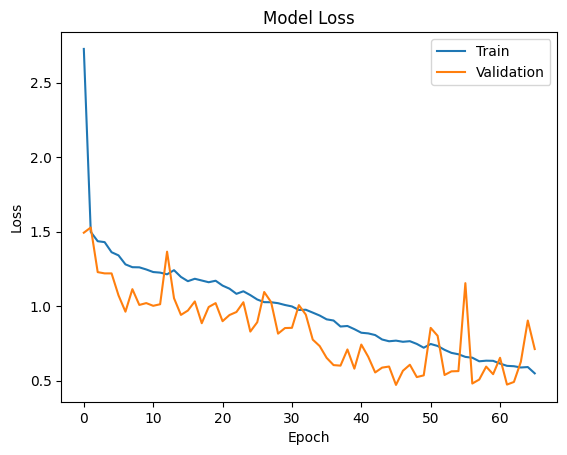

In [13]:
# Loss history summary
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

#### Metrics

88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


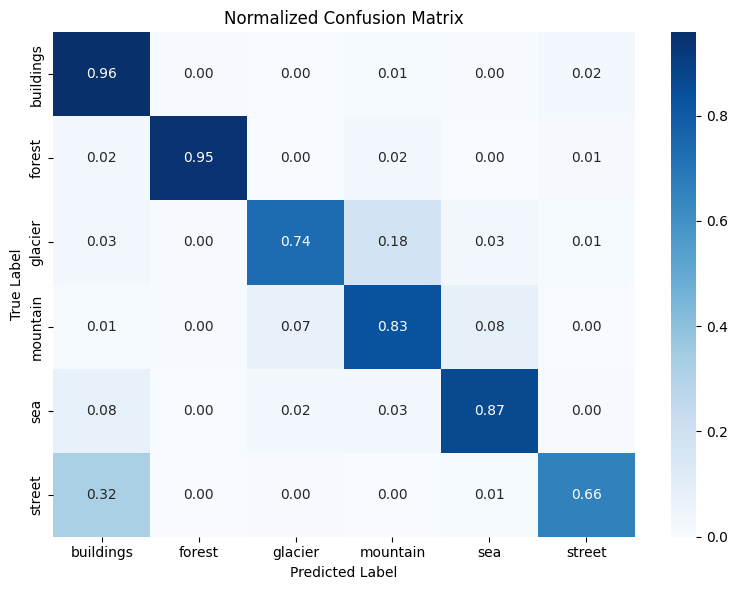

              precision    recall  f1-score   support

   buildings       0.66      0.96      0.78       430
      forest       0.98      0.95      0.96       431
     glacier       0.88      0.74      0.80       506
    mountain       0.78      0.83      0.81       522
         sea       0.86      0.87      0.86       461
      street       0.93      0.66      0.77       456

    accuracy                           0.83      2806
   macro avg       0.85      0.83      0.83      2806
weighted avg       0.85      0.83      0.83      2806



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
images = []
labels = []

for batch_images, batch_labels in val_data.unbatch():
    images.append(batch_images)
    labels.append(batch_labels)

images = tf.stack(images)
labels = tf.stack(labels)

predictions = model.predict(images, batch_size=32)
predicted_classes = tf.argmax(predictions, axis=1)

cm = confusion_matrix(labels.numpy(), predicted_classes.numpy())
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

print(classification_report(labels.numpy(), predicted_classes.numpy(), target_names=classes))